In [12]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torch.distributions import Dirichlet, Uniform
from torchinfo import summary

In [13]:
#transforming and downloading the MNIST
transform = v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [14]:
#creating data loader
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

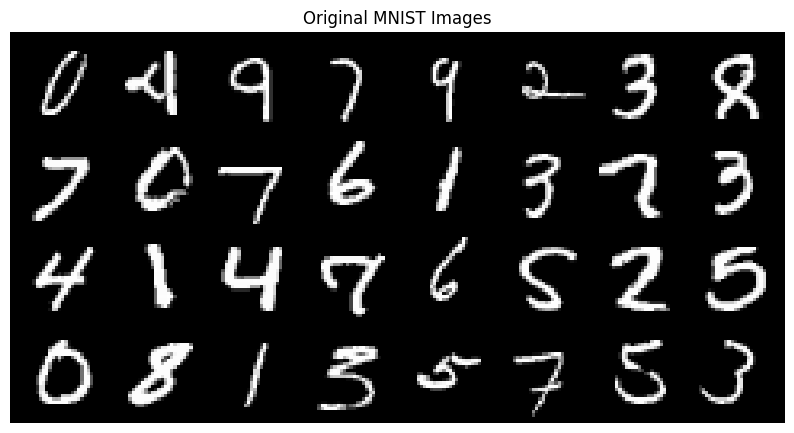

In [15]:
#function to visualize some samples off dataset
def show_images(images, title=None, nrow=8):

  grid = make_grid(images, nrow=nrow, padding=2, normalize=True)
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(grid, (1,2,0))) #changing order of grid to (H, W, C)
  if title:
    plt.title(title)
  plt.axis('off')
  plt.show()

#getting new batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

#plotting images
show_images(images[:32], "Original MNIST Images")

In [16]:
latent_dim = 20
alpha_prior = 0.3

In [17]:
class DirichletEncoder(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.fc_concentration = nn.Linear(128*4*4, latent_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1)
        concentration = F.softplus(self.fc_concentration(x)) + 1e-6
        return concentration

class DirichletDecoder(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*4*4)
        self.conv_trans_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 128, 4, 4)
        return self.conv_trans_layers(x)

In [ ]:
def reparameterize(concentration):
    dirichlet = Dirichlet(concentration)
    return dirichlet.rsample() 

In [19]:
class DirichletVAE(nn.Module):
    def __init__(self, latent_dim=latent_dim, alpha_prior=alpha_prior):
        super().__init__()
        self.encoder = DirichletEncoder(latent_dim)
        self.decoder = DirichletDecoder(latent_dim)
        self.alpha_prior = torch.ones(latent_dim) * alpha_prior
        self.latent_dim = latent_dim

    def forward(self, x):
        concentration = self.encoder(x)
        z = reparameterize(concentration)
        x_recon = self.decoder(z)
        return x_recon, z, concentration

    def loss_function(self, x, x_recon, concentration):
        # Reconstruction loss
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / x.size(0)

        q_dist = Dirichlet(concentration)
        p_dist = Dirichlet(self.alpha_prior.expand_as(concentration))
        kl_loss = torch.distributions.kl_divergence(q_dist, p_dist).mean()

        return recon_loss + kl_loss, recon_loss, kl_loss

In [20]:
# Hyperparameters
learning_rate = 25e-4
num_epochs = 30

#Modelling
model = DirichletVAE(latent_dim, alpha_prior=alpha_prior)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
print(summary(model, input_size=(1,1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
DirichletVAE                             [1, 1, 28, 28]            --
├─DirichletEncoder: 1-1                  [1, 20]                   --
│    └─Sequential: 2-1                   [1, 128, 4, 4]            --
│    │    └─Conv2d: 3-1                  [1, 32, 14, 14]           320
│    │    └─BatchNorm2d: 3-2             [1, 32, 14, 14]           64
│    │    └─LeakyReLU: 3-3               [1, 32, 14, 14]           --
│    │    └─Conv2d: 3-4                  [1, 64, 7, 7]             18,496
│    │    └─BatchNorm2d: 3-5             [1, 64, 7, 7]             128
│    │    └─LeakyReLU: 3-6               [1, 64, 7, 7]             --
│    │    └─Conv2d: 3-7                  [1, 128, 4, 4]            73,856
│    │    └─BatchNorm2d: 3-8             [1, 128, 4, 4]            256
│    │    └─LeakyReLU: 3-9               [1, 128, 4, 4]            --
│    └─Linear: 2-2                       [1, 20]                   40,980


In [22]:
#training loop
import time
start = time.perf_counter()
def train(epoch):

  model.train()
  accumulated_recon_loss = 0
  accumulated_kld_loss = 0
  training_loss = 0

  for batch_idx, (data, _) in enumerate(train_loader):
    optimizer.zero_grad()
    recon_batch, z, concentration = model(data)
    batch_total_loss, batch_recon_loss, batch_kld_loss = model.loss_function(data, recon_batch, concentration)

    batch_total_loss.backward()
    training_loss += batch_total_loss.item()
    accumulated_recon_loss += batch_recon_loss.item()
    accumulated_kld_loss += batch_kld_loss.item()
    optimizer.step()

  print(f'Epoch: {epoch} Total Loss: {training_loss / len(train_loader.dataset):.2f} '
          f'Reconstruction Loss: {accumulated_recon_loss /len(train_loader.dataset):.2f} '
          f'KL Loss: {accumulated_kld_loss /len(train_loader.dataset):.2f}')
for epoch in range(1, num_epochs + 1):
  train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

Epoch: 1 Total Loss: 1.19 Reconstruction Loss: 1.06 KL Loss: 0.13
Epoch: 2 Total Loss: 0.95 Reconstruction Loss: 0.77 KL Loss: 0.18
Epoch: 3 Total Loss: 0.91 Reconstruction Loss: 0.72 KL Loss: 0.19
Epoch: 4 Total Loss: 0.89 Reconstruction Loss: 0.70 KL Loss: 0.19
Epoch: 5 Total Loss: 0.88 Reconstruction Loss: 0.69 KL Loss: 0.19
Epoch: 6 Total Loss: 0.87 Reconstruction Loss: 0.68 KL Loss: 0.19
Epoch: 7 Total Loss: 0.86 Reconstruction Loss: 0.67 KL Loss: 0.19
Epoch: 8 Total Loss: 0.86 Reconstruction Loss: 0.66 KL Loss: 0.19
Epoch: 9 Total Loss: 0.85 Reconstruction Loss: 0.66 KL Loss: 0.19
Epoch: 10 Total Loss: 0.85 Reconstruction Loss: 0.66 KL Loss: 0.19
Epoch: 11 Total Loss: 0.84 Reconstruction Loss: 0.65 KL Loss: 0.19
Epoch: 12 Total Loss: 0.84 Reconstruction Loss: 0.65 KL Loss: 0.19
Epoch: 13 Total Loss: 0.84 Reconstruction Loss: 0.65 KL Loss: 0.19
Epoch: 14 Total Loss: 0.84 Reconstruction Loss: 0.64 KL Loss: 0.19
Epoch: 15 Total Loss: 0.83 Reconstruction Loss: 0.64 KL Loss: 0.19
Epoc

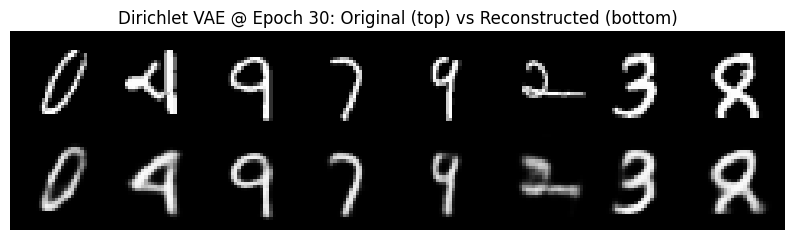

<Figure size 640x480 with 0 Axes>

In [31]:
# reconstructing some images after last epoch
model.eval()
with torch.no_grad():
  sample = images[:8]
  recon, _, _ = model(sample)

  # Show original and reconstructed images
  comparison = torch.cat([sample, recon])
  show_images(comparison, f'Dirichlet VAE @ Epoch {epoch}: Original (top) vs Reconstructed (bottom)')
  plt.savefig('img/dirichlet_vae.png')

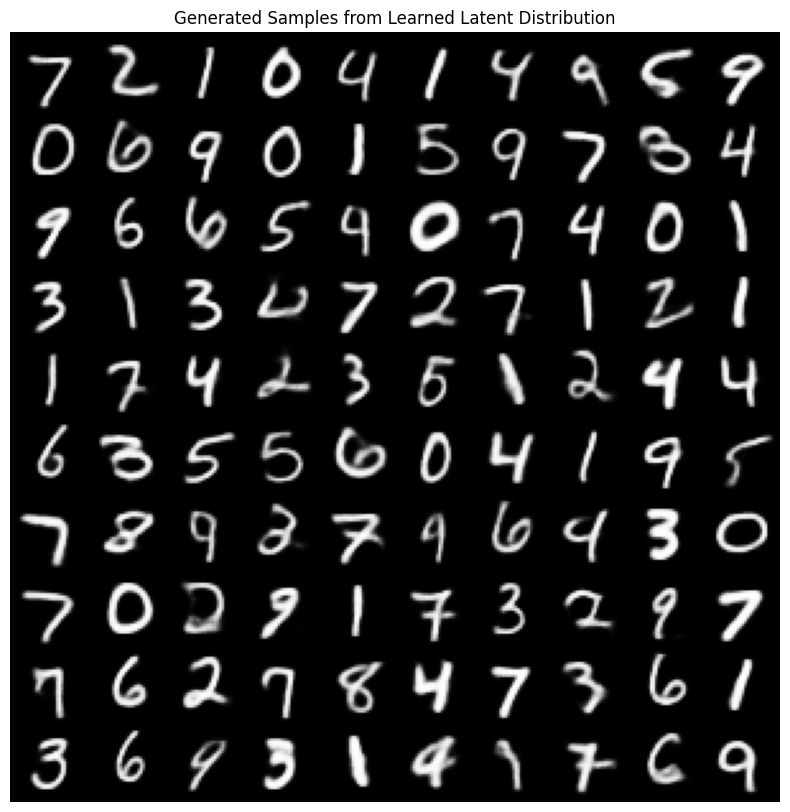

In [24]:
# Generate samples from Dirichlet VAE by sampling from the learned latent distribution of test data
def generate_samples(n=100, nrow=10):
    model.eval()
    latents = []
    with torch.no_grad():
        # Get a batch of test data
        data, _ = next(iter(test_loader))

        # Get the concentration parameters from the encoder
        concentration = model.encoder(data)
        q_z = Dirichlet(concentration)
        z = q_z.sample()

        # Decode the sampled latent vectors
        samples = model.decoder(z[:n])

        show_images(samples, "Generated Samples from Learned Latent Distribution", nrow=nrow)

generate_samples()

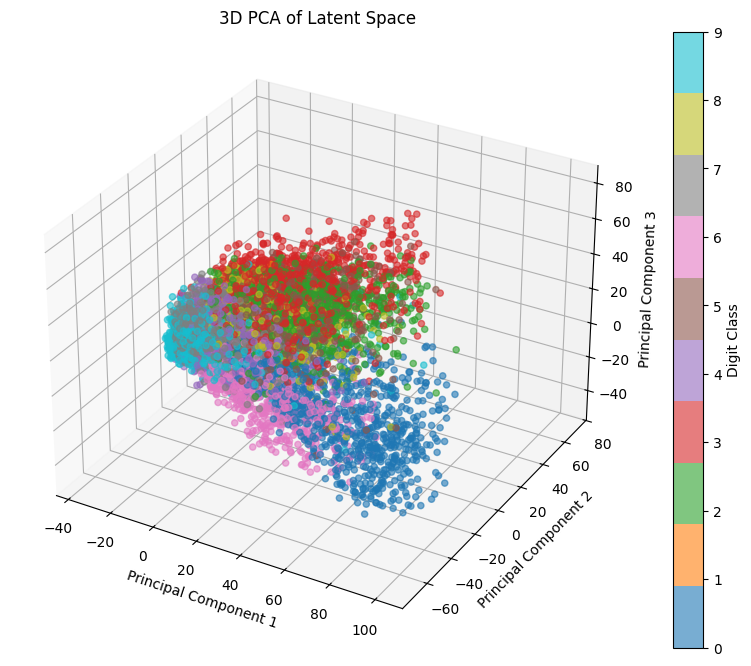

In [25]:
from sklearn.decomposition import PCA

def plot_latent_space_pca(model, data_loader, n_components=3):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            concentration = model.encoder(data) # Get concentration
            latents.append(concentration)
            labels.append(label)

    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()

    # Performing PCA to reduce dimensionality to n_components
    pca = PCA(n_components=n_components)
    latents_reduced = pca.fit_transform(latents)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latents_reduced[:, 0], latents_reduced[:, 1], latents_reduced[:, 2],
                        c=labels, cmap='tab10', alpha=0.6)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('3D PCA of Latent Space')
    fig.colorbar(scatter, ticks=range(10), label='Digit Class')

    plt.show()

plot_latent_space_pca(model, test_loader, n_components=3)